# Predicciones con data de tiendas ficticias

Se tienen dos tiendas, con ventas semanales, las cuales quieren predeir el stock futuro

### Para este ejercicio, se hacen los siguientes supuestos:

La demanda futura solo depende de la demanda pasada y no está influenciada por factores no registrados.
Los patrones observados en el pasado continuarán de manera similar en el futuro.
Las anomalías y valores atípicos se tratan adecuadamente o son fenómenos raros.



In [38]:
#Importaciones varias:

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [39]:
# Cargar datos
data_store_A = pd.read_csv('data_store_A (1).csv')
data_store_B = pd.read_csv('data_store_B (1).csv')

# Convertir la columna 'ds' a datetime y establecer como índice
data_store_A['ds'] = pd.to_datetime(data_store_A['ds'])
data_store_A.set_index('ds', inplace=True)
data_store_B['ds'] = pd.to_datetime(data_store_B['ds'])
data_store_B.set_index('ds', inplace=True)


In [40]:
data_store_A.head() #revisar cómo queda

,y
ds,
2017-01-01,416
2017-01-02,321
2017-01-03,394
2017-01-04,465
2017-01-05,497


In [41]:
data_store_B.head()

,y
ds,
2019-12-27,104
2019-12-28,671
2019-12-29,502
2019-12-30,844
2019-12-31,704


# 1. EDA 

In [42]:
# Descripción estadística
print(data_store_A.describe())
print(data_store_B.describe())



                 y
count  2642.000000
mean    432.386071
std     150.736242
min      37.000000
25%     329.250000
50%     424.000000
75%     532.750000
max     983.000000
                 y
count  1556.000000
mean    735.429949
std     357.322761
min       2.000000
25%     491.750000
50%     659.000000
75%     930.500000
max    2212.000000


array([[<AxesSubplot: title={'center': 'y'}>]], dtype=object)

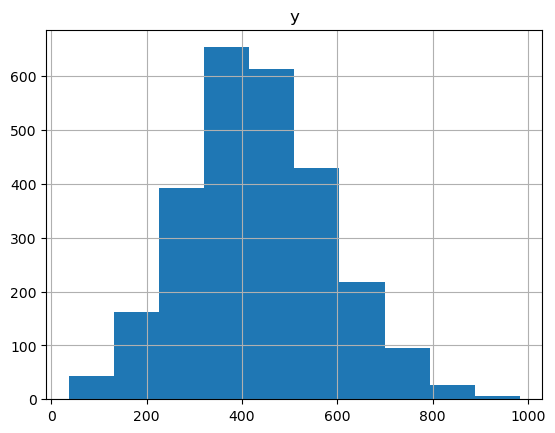

In [43]:
#histograma de store_a:
data_store_A.hist()

El histograma muestra que la mayoría de las ventas diarias se agrupan alrededor de la media de 432 unidades, pero hay una cola hacia valores más altos, lo que sugiere que hay días con ventas significativamente mayores.

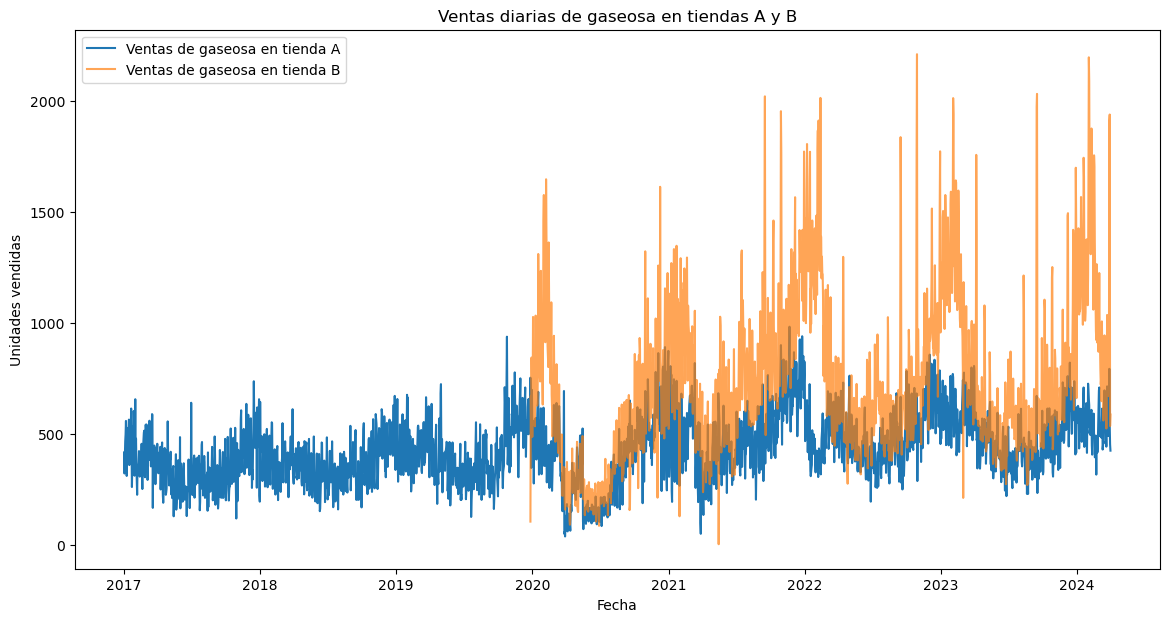

In [44]:
# Visualización de las series
plt.figure(figsize=(14, 7))
plt.plot(data_store_A.index, data_store_A['y'], label='Ventas de gaseosa en tienda A')
plt.plot(data_store_B.index, data_store_B['y'], label='Ventas de gaseosa en tienda B', alpha=0.7)
plt.title('Ventas diarias de gaseosa en tiendas A y B')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.show()

En el gráfico, podemos observar que en la tienda A la data parte de antes, del 2017 en cambio en la tienda B parte desde el 2020. Se aprecia que en ambos casos parece haber cierta estacionalidad, la que debe ser corroborada. Además, si bien las ventas de la tienda tienda B se comportan de manera similar a las de la  tienda A se observa una excepcion al principio del año, donde la tienda B matiene un ivel de consumo alto de la gaseosa no solo a fin de año sino que los primeros meses del nuevo año. 

Por otro lado, se observa que la estacionalidad es anual, queda bastante claro que tiene forma de U donde las puntas representan fin de año y hay un declive progresivo hasta fin de año, para repuntar cuando se acerca el fin de laño nuevamente. Esta estacionalidad es más marcada en la tienda B.

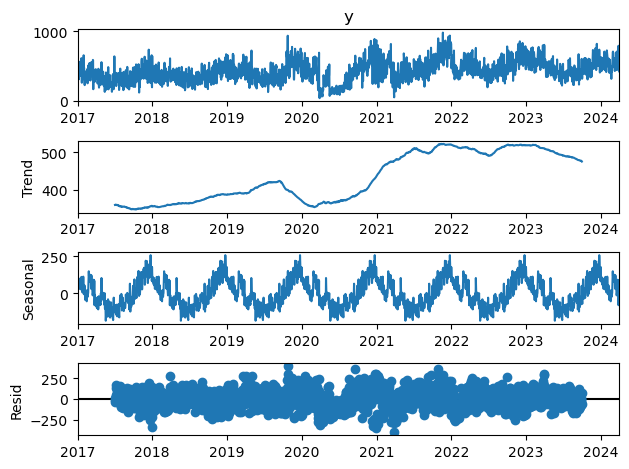

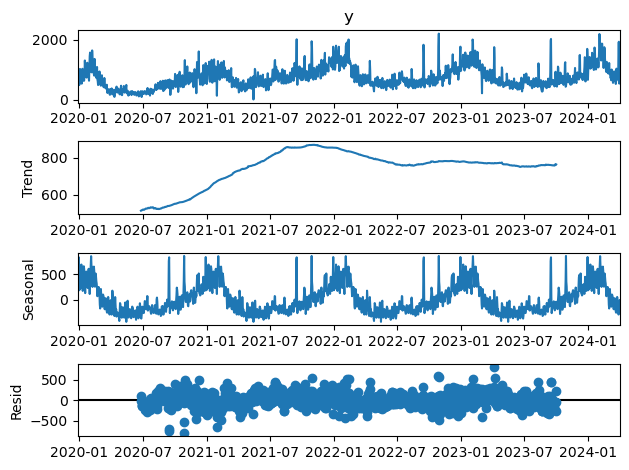

In [45]:
# Descomposición de la serie temporal para A, se añade el hiperparámetro 365 para establecerlo anual
result_A = seasonal_decompose(data_store_A['y'], model='additive', period=365)
result_A.plot()
plt.show()

# Descomposición de la serie temporal para B, se añade el hiperparámetro 365 para establecerlo anual
result_B = seasonal_decompose(data_store_B['y'], model='additive', period=365)
result_B.plot()
plt.show()


En ambas tiendas se observa que la tendencia al alza se detiene el 2022, quedando relativamente uniforme.

## Prueba de Estacionariedad

Para comprobar la hipotesis de estacionalidad, se realiza una prueba ADF, esto sirve para elegir un modelo ad-hoc para el analisis posterior.

In [46]:
# Prueba ADF para Store A
result_adf_A = adfuller(data_store_A['y'])
print('ADF para la tienda A: %f' % result_adf_A[0])
print('p-value para la tienda A: %f' % result_adf_A[1])

# Prueba ADF para Store B
result_adf_B = adfuller(data_store_B['y'])
print('ADF para la tienda B: %f' % result_adf_B[0])
print('p-value para la tienda A: %f' % result_adf_B[1])

ADF para la tienda A: -3.495767
p-value para la tienda A: 0.008096
ADF para la tienda B: -3.064924
p-value para la tienda A: 0.029260


Ambas series temporales de las tiendas A y B son estacionarias según la prueba ADF. Esto es beneficioso para el análisis y modelado futuro, ya que no necesitaríamos transformar estas series para estabilizar su media y varianza. Podemos proceder con modelos de predicción que asumen estacionariedad, como ARIMA, sin necesidad de diferenciar primero los datos. Esto simplifica el modelado y puede mejorar la precisión de las predicciones.

Estos resultados iniciales nos servirán a futuro para poder modificar los parametros de ARIMA o elegir nuevos tipos de modelos

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

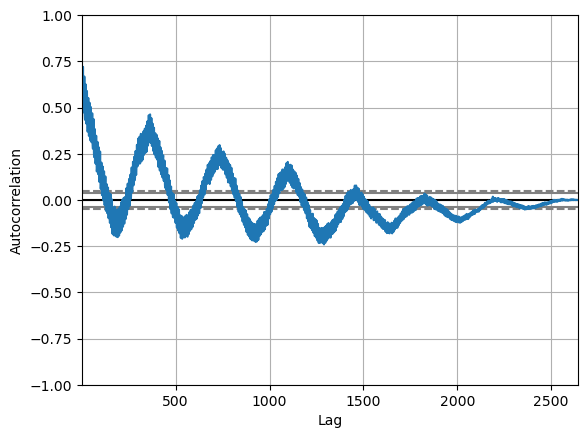

In [47]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(data_store_A.y) 
#Horizontal bands indicate 95% and 99% (dashed) confidence bands

#los valores están altamente correlacionados con sus valores recientes, pero esta correlación disminuye a medida que nos alejamos en el tiempo.
#La presencia de autocorrelación significativa en los primeros lags puede sugerir la necesidad de incluir términos autoregresivos en un modelo ARIMA. 
# La disminución gradual en la autocorrelación también puede implicar que se necesite un término de diferenciación para estabilizar la media de la serie temporal.

# División del  dataset en train y test.

Voy a dividir el dataset para poder probar algunos modelos y su performance, previo a decidir cual usar. En el caso de datos para predecir una serie temporal, es buena idea ocupar el primer 80% como data de train y la restante de test. 

En caso de querer obtener mejores resultados, el valor de la división de split train test podría variar.

In [48]:
# Definir el tamaño del conjunto de prueba
test_size = int(len(data_store_A) * 0.0115)

# Dividir los datos en entrenamiento y prueba
train_data = data_store_A.iloc[:-test_size]
test_data = data_store_A.iloc[-test_size:]

# Mostrar el tamaño de los conjuntos
print("Tamaño de Train:", train_data.shape[0])
print("Tamaño de Test:", test_data.shape[0])


Tamaño de Train: 2612
Tamaño de Test: 30


In [49]:
# Ajustar el modelo ARIMA al conjunto de entrenamiento
model = SARIMAX(data_store_A['y'], 
                order=(1, 0, 1),             # Parámetros ARIMA (p, d, q)
                seasonal_order=(1, 1, 1, 12) # Parámetros estacionales (P, D, Q, S)
)
results = model.fit()


c:\Users\leikc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\leikc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [50]:
# Configuración del modelo SARIMAX
model = SARIMAX(train_data['y'],
                order=(1, 0, 1),              # Parámetros ARIMA base (p, d, q)
                seasonal_order=(1, 1, 1, 12)) # Parámetros estacionales (P, D, Q, S)

# Ajuste del modelo
results = model.fit()

c:\Users\leikc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\leikc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


c:\Users\leikc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


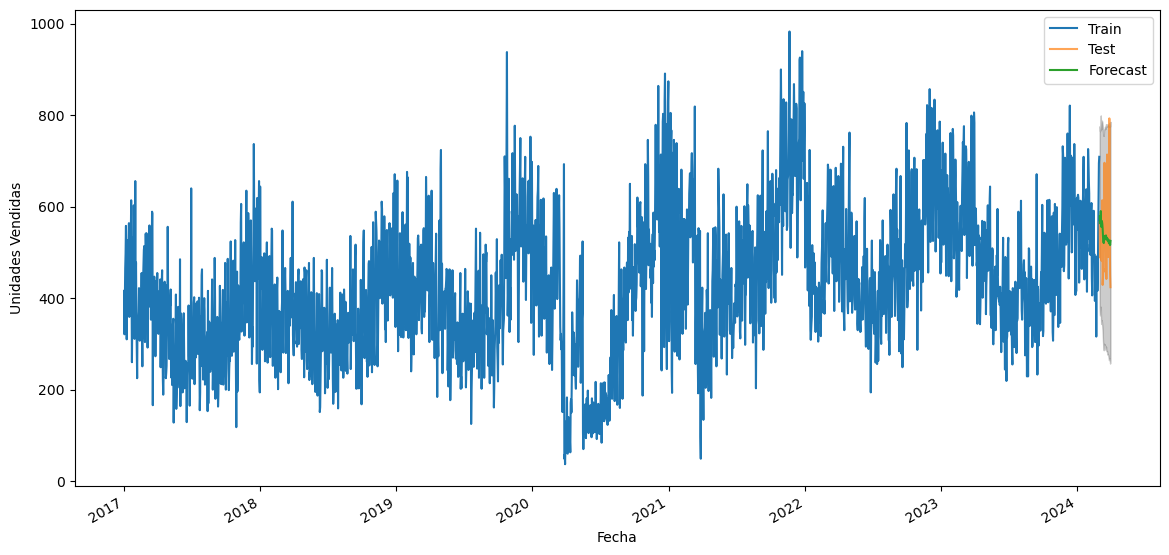

In [51]:
# Generar predicciones
pred = results.get_forecast(steps=len(test_data))
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

# Establecer el índice correcto para las predicciones
pred_mean.index = test_data.index
pred_ci.index = test_data.index

# Visualización de las predicciones contra los valores reales
ax = train_data['y'].plot(label='Train', figsize=(14, 7))
test_data['y'].plot(ax=ax, label='Test', alpha=0.7)
pred_mean.plot(ax=ax, label='Forecast')
ax.fill_between(test_data.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades Vendidas')
plt.legend()
plt.show()


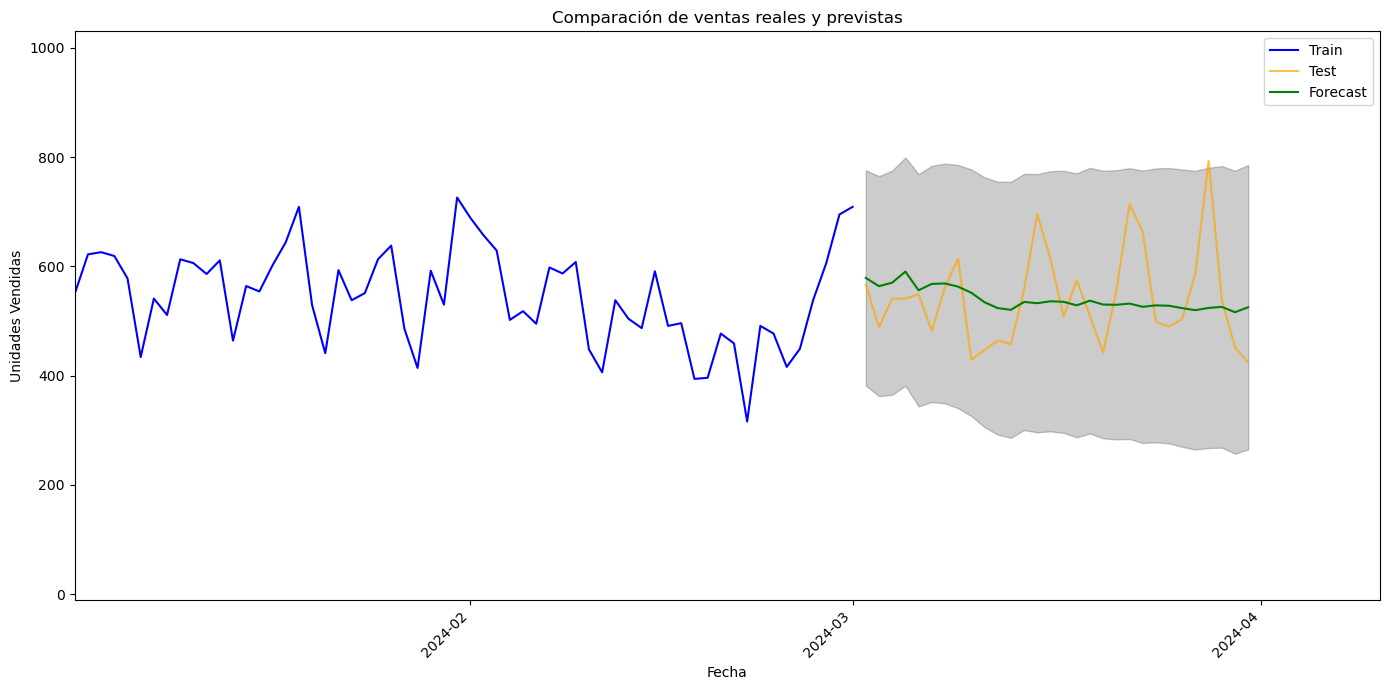

In [52]:
import matplotlib.dates as mdates

# Visualización de las predicciones contra los valores reales
fig, ax = plt.subplots(figsize=(14, 7))
train_data['y'].plot(ax=ax, label='Train', color='blue')
test_data['y'].plot(ax=ax, label='Test', alpha=0.7, color='orange')
pred_mean.plot(ax=ax, label='Forecast', color='green')
ax.fill_between(test_data.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)

# Ajustar el rango de fechas en el eje x para incluir más datos antes del test
start_plot = test_data.index[0] - pd.Timedelta(days=60)  # 60 días antes del inicio del test
end_plot = test_data.index[-1] + pd.Timedelta(days=10)  # 10 días después del final del test

ax.set_xlim([start_plot, end_plot])

# Configuraciones adicionales
ax.set_xlabel('Fecha')
ax.set_ylabel('Unidades Vendidas')
ax.set_title('Comparación de ventas reales y previstas')
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Establece ubicaciones de ticks principales a cada mes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato de fecha para mejorar la legibilidad
plt.xticks(rotation=45)  # Rotar las etiquetas de fecha para mejorar legibilidad
plt.legend()
plt.tight_layout()  # Ajusta el layout para que todo encaje bien
plt.show()



Si bien se observa que el modelo logra una buena predicción para un periodo corto, de 1-3 días, pasado ese tiempo se genera una prediccion subajustada.

Se puede probar con autoarima, además del ajuste de otros hiperparámetros para mejorar la calidad de las predicciones a varios días, pero si consideramos que la línea de prediccion refleja una buena división de la demanda y que el promedio debiera ser cercano, es una buena aproximacion base para el problema.

Se podria incluir información de variables exógenas, como promociones, cierres del local, u otros que puedan influenciar los resultados más alla de solo lo histórico, de esa manera la precision seria mucho mejor.

Finalmente, podemos ocupar modelos como una red neuronal, con LSTM que en lo personal me han dado buenos resultados. Si bien

# 3. LSTM
LSTM es un acrónimo para un modelo long-short memory y es uan red neuronal profunda. 

Un modelo basado en LSTM funciona bien para este tipo de problemas. Para ello debemos escalar la data para que el modelo pueda trabajar de mejor forma, posteriormente hacer unos cambios en la forma que se presentan los datos para entregarselos a la red neuronal

In [53]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Cargar la data y hacer un reshape para que este en la forma en que la RN la pueda procesar
data = data_store_A['y'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
# Ajustar y transformar los datos
data_normalized = scaler.fit_transform(data)

In [54]:
def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60  # Número de pasos de tiempo que quieres usar para predecir el siguiente punto
X, y = create_sequences(data_normalized, time_steps)

In [55]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Remodelar los datos para que se ajusten a lo que espera la capa LSTM en Keras
# La nueva forma debe ser [muestras, pasos de tiempo, características]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [56]:
# Crear el modelo LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')





Epoch 1/100
59/59 [==============================] - 7s 64ms/step - loss: 0.0230 - val_loss: 0.0122 - lr: 0.0010
Epoch 2/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0150 - val_loss: 0.0123 - lr: 0.0010
Epoch 3/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0143 - val_loss: 0.0120 - lr: 0.0010
Epoch 4/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0147 - val_loss: 0.0120 - lr: 0.0010
Epoch 5/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0138 - val_loss: 0.0120 - lr: 0.0010
Epoch 6/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0143 - val_loss: 0.0120 - lr: 0.0010
Epoch 7/100
59/59 [==============================] - 3s 49ms/step - loss: 0.0142 - val_loss: 0.0123 - lr: 0.0010
Epoch 8/100
59/59 [==============================] - 3s 48ms/step - loss: 0.0144 - val_loss: 0.0121 - lr: 0.0010


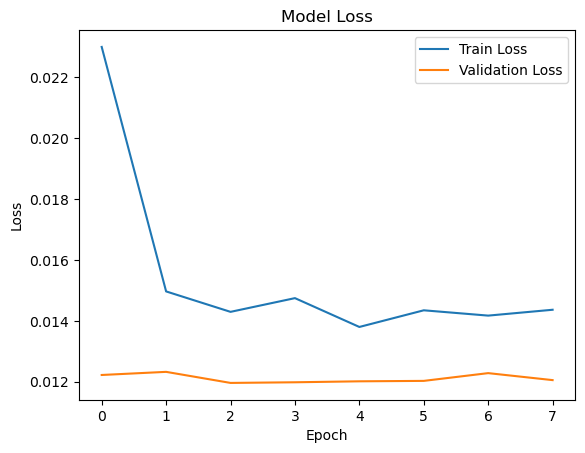

In [57]:
# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

#Reduce LR
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
                    validation_split=0.1, callbacks=[early_stopping, reduce_lr], verbose=1)

# Visualizar el historial de entrenamiento
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


In [58]:
# Realizar predicciones en el conjunto de prueba
predicted_prices = model.predict(X_test)

17/17 [==============================] - 1s 22ms/step


In [59]:
# Revertir la normalización para las predicciones y los valores reales
predicted_prices = scaler.inverse_transform(predicted_prices)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [60]:
# Calcular RMSE
rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
print(f'RMSE: {rmse}')

RMSE: 94.44604586527036


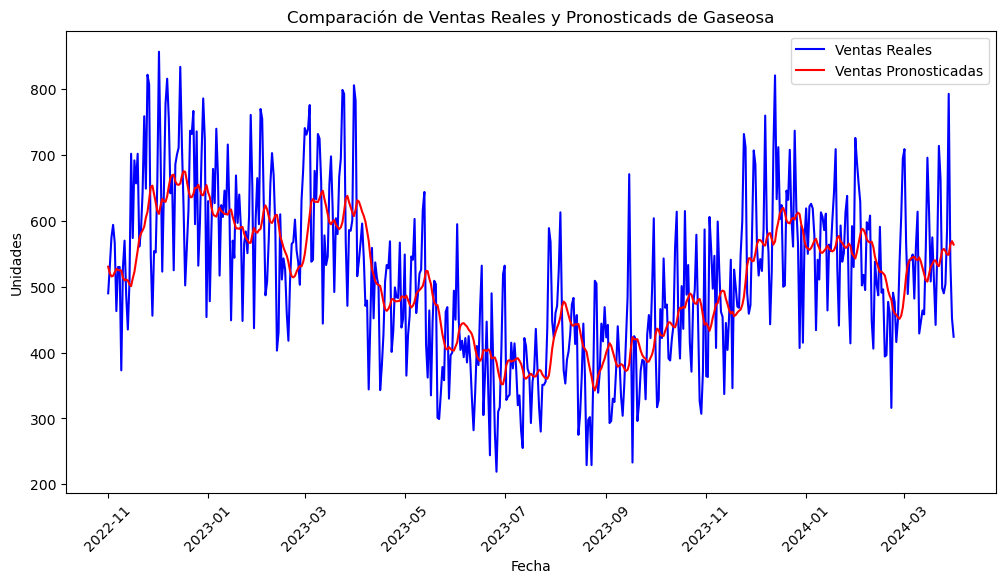

In [61]:
test_dates = data_store_A.index[-len(X_test):]

# Graficar los resultados 
plt.figure(figsize=(12, 6))
plt.plot(test_dates, real_prices, label='Ventas Reales', color='blue')
plt.plot(test_dates, predicted_prices, label='Ventas Pronosticadas', color='red')
plt.title('Comparación de Ventas Reales y Pronosticads de Gaseosa')
plt.xlabel('Fecha')
plt.ylabel('Unidades')
plt.legend()
plt.xticks(rotation=45)  
plt.show()

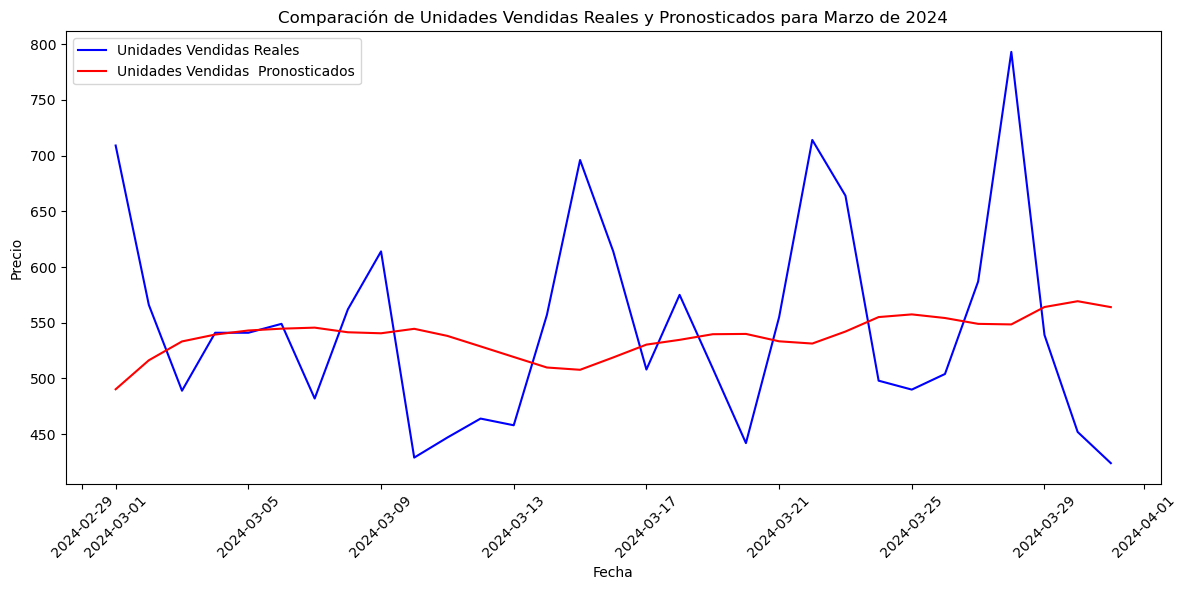

In [62]:
# Filtrar para obtener solo las fechas de marzo de 2024
mask = (test_dates.month == 3) & (test_dates.year == 2024)
march_2024_dates = test_dates[mask]
march_2024_real_prices = real_prices[mask]
march_2024_predicted_prices = predicted_prices[mask]

# Graficar los resultados solo para marzo de 2024
plt.figure(figsize=(12, 6))
plt.plot(march_2024_dates, march_2024_real_prices, label='Unidades Vendidas Reales', color='blue')
plt.plot(march_2024_dates, march_2024_predicted_prices, label='Unidades Vendidas  Pronosticados', color='red')
plt.title('Comparación de Unidades Vendidas Reales y Pronosticados para Marzo de 2024')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout()  
plt.show()



In [63]:
# Definir las fechas de Semana Santa 2024, suponiendo esta como el fin de semana y feriados, no la semana completa
semana_santa_dates = pd.date_range(start="2024-03-28", end="2024-03-31")

# Preparar datos de entrada para estas fechas
X_semana_santa = []
for date in semana_santa_dates:
    idx = data_store_A.index.get_loc(date)
    X_semana_santa.append(data_normalized[idx-60:idx].reshape(1, 60, 1))

# Predecir usando el modelo
predictions = np.array([model.predict(x) for x in X_semana_santa]).squeeze()

# Desnormalizar las predicciones
predicted_units_descaled = scaler.inverse_transform(predictions.reshape(-1, 1))

# Sumar las predicciones desnormalizadas para obtener el total de unidades necesarias
total_units = np.sum(predicted_units_descaled)
print(f"Total de unidades necesarias para Semana Santa 2024: {total_units}")


1/1 [==============================] - 0s 33ms/step
Total de unidades necesarias para Semana Santa 2024: 2245.8916015625


In [64]:
# Extraer los valores reales para Semana Santa 2024
real_units = data_store_A.loc[semana_santa_dates]['y']

# Asegúrate de que las fechas coincidan exactamente en el dataframe
if len(real_units) != len(predicted_units_descaled):
    print("Advertencia: La cantidad de predicciones no coincide con la cantidad de valores reales disponibles.")

# Calcular RMSE entre los valores reales y las predicciones desnormalizadas
rmse = np.sqrt(mean_squared_error(real_units, predicted_units_descaled))
print(f'RMSE entre los valores reales y las predicciones para Semana Santa 2024: {rmse}')

# Mostrar los valores reales y predichos
comparison_df = pd.DataFrame({
    'Fecha': semana_santa_dates,
    'Real': real_units.values,
    'Predicción': predicted_units_descaled.flatten()  # Asegurarse de que estén en el mismo formato
})
print(comparison_df)

RMSE entre los valores reales y las predicciones para Semana Santa 2024: 153.11369453096012
       Fecha  Real  Predicción
0 2024-03-28   793  548.489258
1 2024-03-29   539  564.099487
2 2024-03-30   452  569.307251
3 2024-03-31   424  563.995483


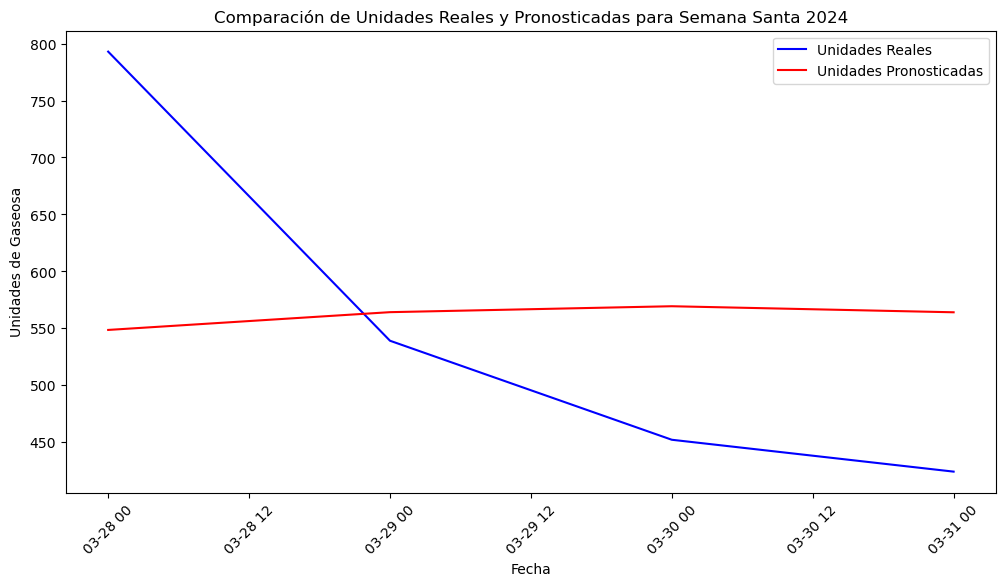

In [65]:
plt.figure(figsize=(12, 6))
plt.plot(comparison_df['Fecha'], comparison_df['Real'], label='Unidades Reales', color='blue')
plt.plot(comparison_df['Fecha'], comparison_df['Predicción'], label='Unidades Pronosticadas', color='red')
plt.title('Comparación de Unidades Reales y Pronosticadas para Semana Santa 2024')
plt.xlabel('Fecha')
plt.ylabel('Unidades de Gaseosa')
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [66]:
# Calcula la suma total de las unidades predichas y reales
total_real_units = np.sum(real_units)
total_predicted_units = np.sum(predicted_units_descaled)

# Calcula el ratio de unidades predichas sobre unidades reales
ratio_predicted_to_real = total_predicted_units / total_real_units

# Mostrar los resultados
print(f"Total de unidades reales durante Semana Santa 2024: {total_real_units}")
print(f"Total de unidades predichas durante Semana Santa 2024: {total_predicted_units}")
print(f"Ratio de unidades predichas a unidades reales: {ratio_predicted_to_real:.2f}")


Total de unidades reales durante Semana Santa 2024: 2208
Total de unidades predichas durante Semana Santa 2024: 2245.8916015625
Ratio de unidades predichas a unidades reales: 1.02


## Conclusiones:
Podemos observar que el modelo es bastante preciso para el pronóstico, pese a que las curvas van de manera diferente, esto porque se uso RMSE para la optimizacion que va compensando la perdida y ganancia, haciendo que a veces se cosidere mas y a vces menos, pero permita generalizar de manera adecuada los valores. Para este analisis se consideró "semana santa" como los 4 dias del jueves al domingo y no la semana completa.


## Mejoras futuras:

Es probable que se deba considerar un sobreajuste, debido principalmente a poible filtración de datos en el minmaxscaler o la red neuronal. Existen amplias opciones de mejora en lo que a la arquitectura de la red se refiere.
Finalmente, es posible que el modelo SARIMA también tenga mucho potencial, ya que la generalizacion que se logró es buena, no se descarta poder encontrar mejores valores u otro tipo de ajustes para mejorar aun mas ese modelo. 